In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, ClassLabel, DatasetDict
import numpy as np

In [3]:
dataset = load_dataset("Densu341/Fresh-rotten-fruit")

In [4]:
remove_labels = [18, 20, 16, 13, 2, 5, 7, 9]
labels = np.array(dataset["train"]["label"])
mask = ~np.isin(labels, remove_labels)

# 3. 필요 없는 라벨 제거
clean_dataset = dataset["train"].select(np.where(mask)[0])

# 4. train/val split
dataset = clean_dataset.train_test_split(test_size=0.2)
train_dataset, val_dataset = dataset["train"], dataset["test"]

# 5. 실제 남은 라벨 인덱스 및 이름 추출
unique_labels = sorted(set(train_dataset["label"]) | set(val_dataset["label"]))
all_labels = [train_dataset.features["label"].int2str(i) for i in unique_labels]

# 6. 새로운 ClassLabel 정의
new_classlabel = ClassLabel(num_classes=len(all_labels), names=all_labels)

# 7. 라벨 값 재매핑
def remap_labels(example):
    label_name = train_dataset.features["label"].int2str(example["label"])
    example["label"] = all_labels.index(label_name)
    return example

train_dataset = train_dataset.map(remap_labels)
val_dataset   = val_dataset.map(remap_labels)

train_dataset = train_dataset.cast_column("label", new_classlabel)
val_dataset   = val_dataset.cast_column("label", new_classlabel)

# 8. 최종 DatasetDict 생성
final_dataset = DatasetDict({
    "train": train_dataset,
    "test": val_dataset
})

Map:   0%|          | 0/21486 [00:00<?, ? examples/s]

Map:   0%|          | 0/5372 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/21486 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5372 [00:00<?, ? examples/s]

In [5]:
#테스트용
print("최종 라벨 목록:", final_dataset["train"].features["label"].names)



print("train 라벨 최소:", min(final_dataset["train"]["label"]))
print("train 라벨 최대:", max(final_dataset["train"]["label"]))
print("고유 라벨 집합:", sorted(set(final_dataset["train"]["label"])))

# 2. 라벨 이름과 매핑 확인
print("라벨 이름 목록:", final_dataset["train"].features["label"].names)

# 3. 샘플 몇 개 찍어보기
for i in range(5):
    label_id = final_dataset["train"][i]["label"]
    label_name = final_dataset["train"].features["label"].int2str(label_id)
    print(f"샘플 {i}: 라벨ID={label_id}, 라벨이름={label_name}")

최종 라벨 목록: ['freshapples', 'freshbanana', 'freshcapsicum', 'freshcucumber', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencapsicum', 'rottencucumber', 'rottenoranges', 'rottenpotato', 'rottentomato']
train 라벨 최소: 0
train 라벨 최대: 13
고유 라벨 집합: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
라벨 이름 목록: ['freshapples', 'freshbanana', 'freshcapsicum', 'freshcucumber', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencapsicum', 'rottencucumber', 'rottenoranges', 'rottenpotato', 'rottentomato']
샘플 0: 라벨ID=2, 라벨이름=freshcapsicum
샘플 1: 라벨ID=8, 라벨이름=rottenbanana
샘플 2: 라벨ID=1, 라벨이름=freshbanana
샘플 3: 라벨ID=7, 라벨이름=rottenapples
샘플 4: 라벨ID=0, 라벨이름=freshapples


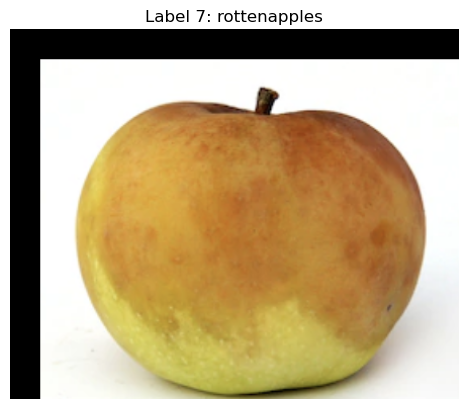

In [6]:
import matplotlib.pyplot as plt

target_label = 7  # 확인하고 싶은 라벨 인덱스

# 해당 라벨의 샘플 하나 찾기
for sample in train_dataset:
    if sample["label"] == target_label:
        image = sample["image"]
        break

# 라벨 인덱스 → 라벨 이름 변환
label_name = train_dataset.features["label"].int2str(target_label)

# 시각화
plt.imshow(image)
plt.title(f"Label {target_label}: {label_name}")
plt.axis("off")
plt.show()

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])  # ImageNet 기준
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# --------------------------------------------------
# PyTorch Dataset 래퍼
# --------------------------------------------------
class FruitHFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"].convert("RGB")  # RGBA → RGB
        label = sample["label"]                # 이미 0~N-1 정수
        if self.transform:
            image = self.transform(image)
        return image, label

# --------------------------------------------------
# DataLoader 생성
# --------------------------------------------------
train_loader = DataLoader(
    FruitHFDataset(final_dataset["train"], transform=train_transform),
    batch_size=32, shuffle=True
)
val_loader = DataLoader(
    FruitHFDataset(final_dataset["test"], transform=val_transform),
    batch_size=32, shuffle=False
)

num_classes = len(final_dataset["train"].features["label"].names)

In [8]:
import torch
from torchvision import models
import torch.nn as nn
from huggingface_hub import hf_hub_download

# 1. 체크포인트 다운로드
ckpt_path = hf_hub_download("abelkrw/fruit-classifier", filename="resnet18_fruit_classifier.pth")

# 2. 모델 정의 (우리 데이터셋 클래스 수 반영)
num_classes = len(final_dataset["train"].features["label"].names)
model = models.resnet18(pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# 3. 체크포인트 로드 (strict=False)
state_dict = torch.load(ckpt_path, map_location="cpu")

# fc.* 키 제거
for key in list(state_dict.keys()):
    if key.startswith("fc."):
        del state_dict[key]

# 나머지 가중치만 로드
model.load_state_dict(state_dict, strict=False)


c:\Users\rkdrn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rkdrn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

C:\Users\rkdrn\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rkdrn\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rkdrn\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rkdrn\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


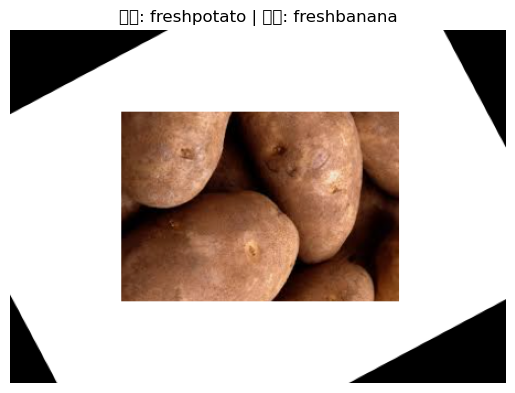

In [ ]:
#테스트용

import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# -----------------------------
# 1. 전처리 정의
# -----------------------------
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# -----------------------------
# 2. 샘플 하나 선택
# -----------------------------
sample = final_dataset["test"][0]
image = sample["image"].convert("RGB")
label_id = sample["label"]
label_name = final_dataset["test"].features["label"].int2str(label_id)

# -----------------------------
# 3. 모델 추론
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

x = inference_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(x)
    pred_id = logits.argmax(dim=-1).item()
    pred_name = final_dataset["test"].features["label"].int2str(pred_id)

# -----------------------------
# 4. 이미지 시각화
# -----------------------------
plt.imshow(image)
plt.axis("off")
plt.title(f"실제: {label_name} | 예측: {pred_name}")
plt.show()


In [13]:
model = model.to(device)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# -----------------------------
# 1. Transform 정의
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

# -----------------------------
# 2. PyTorch Dataset 래퍼
# -----------------------------
class FruitHFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"].convert("RGB")
        label = sample["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

train_ds = FruitHFDataset(final_dataset["train"], transform=train_transform)
val_ds   = FruitHFDataset(final_dataset["test"],  transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

# -----------------------------
# 3. 백본 freeze (fc만 학습)
# -----------------------------
for name, param in model.named_parameters():
    if not name.startswith("fc."):
        param.requires_grad = False

# -----------------------------
# 4. 학습 준비
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용중인 장치:", device)  # 확인용 출력

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # fc 레이어만 학습

# -----------------------------
# 5. 미니 학습 루프
# -----------------------------
for epoch in range(5):  # 테스트로 5 epoch만
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # ← 여기에서 GPU로 이동

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_loss = total_loss / len(train_loader)

    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # ← 검증도 GPU로 이동
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


사용중인 장치: cuda


KeyboardInterrupt: 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
next(model.parameters()).device

cuda


device(type='cpu')